# $\mathbf{\Gamma}_1$ and $\mathbf{D}$ calibration with L1.01 norm using Iteratively Reweighted Least-Squares (IRLS)
Christian Jaques, CBI group, Idiap

This notebook implements Section 3.2 of our paper "Temporal Super-Resolution Microscopy Using a Hue-Encoded Shutter", OSA BOE XXXX 2019.

christian.jaques@idiap.ch

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from colour_demosaicing import demosaicing_CFA_Bayer_bilinear 
from utils import *
from solver import * 
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)

## Load + debayer files

(1200, 1000, 31)


Text(0.5,1,'RGB values over the whole calibration set of images')

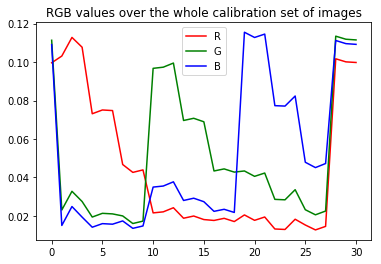

In [2]:
directory = '../data/'
filename = directory + 'figure2_calib.npy'
if('figure2' in filename): # special case for figure2
    figure2 = True
else:
    figure2 = False

calib_sequence = np.load(filename)

print(calib_sequence.shape)
# debayer sequence
calib_sequence = np.swapaxes(calib_sequence, 0, 2)
N, X, Y = calib_sequence.shape
calib_rgb = np.zeros((N,X,Y,3))
rgb_mean = np.zeros((N,3))
for i in range(N):
    calib_rgb[i] = demosaicing_CFA_Bayer_bilinear(calib_sequence[i])/ 255.
    rgb_mean[i,0] = np.mean(calib_rgb[i,:,:,0])
    rgb_mean[i,1] = np.mean(calib_rgb[i,:,:,1])
    rgb_mean[i,2] = np.mean(calib_rgb[i,:,:,2])

plt.plot(rgb_mean[:,0], 'r')
plt.plot(rgb_mean[:,1], 'g')
plt.plot(rgb_mean[:,2], 'b')
plt.legend(['R', 'G', 'B'])
plt.title('RGB values over the whole calibration set of images')

## Extract calibration area 
Select a region of interest that is static, and ideally that comprises a high variety of greylevels (black/white).

<Figure size 432x288 with 0 Axes>

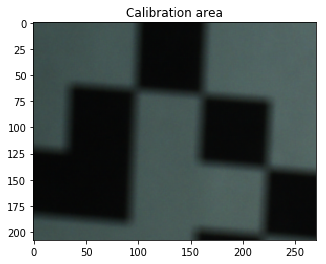

<Figure size 432x288 with 0 Axes>

In [3]:
image = calib_rgb[0]
could_load_qtgraph = True

if(could_load_qtgraph is True):
    roi = select_roi(image, 'Calibration area')

    xw = int(roi.pos()[0])
    yw = int(roi.pos()[1])
    ww = int(roi.size()[0])
    hw = int(roi.size()[1])
else:
    xw = 400
    yw = 800
    ww = 100
    hw = 100

xw1 = xw
xw2 = xw + ww
yw1 = yw
yw2 = yw + hw

plt.imshow(image[xw1:xw2, yw1:yw2])
plt.title('Calibration area')
plt.figure()

## Build $\mathbf{A}_{\text{cal}}$ matrix

See Equation (15) in paper, we have:
$ \mathbf{Y}_{\text{cal}} = \mathbf{A}_{\text{cal}}\begin{pmatrix} \mathbf{\Gamma}_1 \\ \mathbf{D} \end{pmatrix}.$

### Special case for figure 2 
The illumination sequence changed between figure 2 and the following figures, hence different values here.

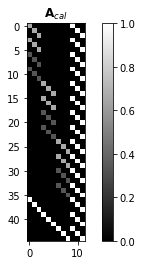

In [4]:
if(figure2 is True):
    all_on = 0
    r_011a = 5
    r_011b = 6
    r_001a = 8
    r_001b = 9
    g_011a = 14
    g_011b = 15
    g_001a = 16
    g_001b = 17
    b_011a = 24
    b_011b = 23
    b_001a = 25
    b_001b = 26
    r_111 = 2
    g_111 = 11
    b_111 = 20

    P = 15 # number of different illumination patterns for calibration
    C = 3 # number of measurement channels (RGB)
    L = 3 # number of lights
    lowish = 0 # used to add background illumination

    S = np.zeros((P*C, (L+1)*C))
    I3 = np.eye(3)
    # R011a
    S[0:3,0:3] = 2./3. * I3
    S[0:3,3:6] = 2./3. * lowish * I3
    S[0:3,6:9] = 2./3. * lowish * I3
    S[0:3,9:12] = I3
    # R011b
    S[3:6,0:3] = 2./3. * I3
    S[3:6,3:6] = 2./3. * lowish * I3
    S[3:6,6:9] = 2./3. * lowish * I3
    S[3:6,9:12] = I3
    # R001a
    S[6:9,0:3] = 1./3. * I3
    S[6:9,3:6] = 1./3. * lowish * I3
    S[6:9,6:9] = 1./3. * lowish * I3
    S[6:9,9:12] = I3
    # R001b
    S[9:12,0:3] = 1./3. * I3
    S[9:12,3:6] = 1./3. * lowish * I3
    S[9:12,6:9] = 1./3. * lowish * I3
    S[9:12,9:12] = I3
    # G011a
    S[12:15,3:6] = 2./3. * I3
    S[12:15,0:3] = 2./3. * lowish * I3
    S[12:15,6:9] = 2./3. * lowish * I3
    S[12:15,9:12] = I3
    # G011b
    S[15:18,3:6] = 2./3. * I3
    S[15:18,0:3] = 2./3. * lowish * I3
    S[15:18,6:9] = 2./3. * lowish * I3
    S[15:18,9:12] = I3
    # G001a
    S[18:21,3:6] = 1./3. * I3
    S[18:21,0:3] = 1./3. * lowish * I3
    S[18:21,6:9] = 1./3. * lowish * I3
    S[18:21,9:12] = I3
    # G001b
    S[21:24,3:6] = 1./3. * I3
    S[21:24,0:3] = 1./3. * lowish * I3
    S[21:24,6:9] = 1./3. * lowish * I3
    S[21:24,9:12] = I3
    # B011a
    S[24:27,6:9] = 2./3. * I3
    S[24:27,0:3] = 2./3. * lowish * I3
    S[24:27,3:6] = 2./3. * lowish * I3
    S[24:27,9:12] = I3
    # B011b
    S[27:30,6:9] = 2./3. * I3
    S[27:30,0:3] = 2./3. * lowish * I3
    S[27:30,3:6] = 2./3. * lowish * I3
    S[27:30,9:12] = I3
    # B001a
    S[30:33,6:9] = 1./3. * I3
    S[30:33,0:3] = 1./3. * lowish * I3
    S[30:33,3:6] = 1./3. * lowish * I3
    S[30:33,9:12] = I3
    # B001b
    S[33:36,6:9] = 1./3. * I3
    S[33:36,0:3] = 1./3. * lowish * I3
    S[33:36,3:6] = 1./3. * lowish * I3
    S[33:36,9:12] = I3
    # r_111
    S[36:39,0:3] = I3
    S[36:39,3:6] = lowish * I3
    S[36:39,6:9] = lowish * I3
    S[36:39,9:12] = I3
    # g_111
    S[39:42,3:6] = I3
    S[39:42,0:3] = lowish * I3
    S[39:42,6:9] = lowish * I3
    S[39:42,9:12] = I3
    # b_111
    S[42:45,6:9] = I3
    S[42:45,0:3] = lowish * I3
    S[42:45,3:6] = lowish * I3
    S[42:45,9:12] = I3

    plt.imshow(S, interpolation='nearest', cmap='gray')
    plt.colorbar()
    plt.title('$\mathbf{A}_{cal}$')

### Illumination sequence (given in Arduino calibration sketch) used for all but figure 2

In [5]:
if(figure2 is False):
    all_on = 1
    r_011a = 7
    r_011b = 8
    r_001a = 10
    r_001b = 9
    g_011a = 16
    g_011b = 17
    g_001a = 19
    g_001b = 20
    b_011a = 25
    b_011b = 26
    b_001a = 27
    b_001b = 28
    all_off_1 = 32
    all_off_2 = 33
    all_off_3 = 34
    rgb_1 = 37
    rgb_2 = 38
    rgb_3 = 39
    rgb_4 = 40
    rgb_5 = 41
    r_111 = 5
    g_111 = 13
    b_111 = 21
    P = 20 # number of different illumination patterns for calibration
    C = 3 # number of measurement channels (RGB)
    L = 3 # number of lights
    lowish = 0 # used to add background illumination

    S = np.zeros((P*C, (L+1)*C))
    I3 = np.eye(3)
    # R011a
    S[0:3,0:3] = 2./3. * I3
    S[0:3,3:6] = 2./3. * lowish * I3
    S[0:3,6:9] = 2./3. * lowish * I3
    S[0:3,9:12] = I3
    # R011b
    S[3:6,0:3] = 2./3. * I3
    S[3:6,3:6] = 2./3. * lowish * I3
    S[3:6,6:9] = 2./3. * lowish * I3
    S[3:6,9:12] = I3
    # R001a
    S[6:9,0:3] = 1./3. * I3
    S[6:9,3:6] = 1./3. * lowish * I3
    S[6:9,6:9] = 1./3. * lowish * I3
    S[6:9,9:12] = I3
    # R001b
    S[9:12,0:3] = 1./3. * I3
    S[9:12,3:6] = 1./3. * lowish * I3
    S[9:12,6:9] = 1./3. * lowish * I3
    S[9:12,9:12] = I3
    # G011a
    S[12:15,3:6] = 2./3. * I3
    S[12:15,0:3] = 2./3. * lowish * I3
    S[12:15,6:9] = 2./3. * lowish * I3
    S[12:15,9:12] = I3
    # G011b
    S[15:18,3:6] = 2./3. * I3
    S[15:18,0:3] = 2./3. * lowish * I3
    S[15:18,6:9] = 2./3. * lowish * I3
    S[15:18,9:12] = I3
    # G001a
    S[18:21,3:6] = 1./3. * I3
    S[18:21,0:3] = 1./3. * lowish * I3
    S[18:21,6:9] = 1./3. * lowish * I3
    S[18:21,9:12] = I3
    # G001b
    S[21:24,3:6] = 1./3. * I3
    S[21:24,0:3] = 1./3. * lowish * I3
    S[21:24,6:9] = 1./3. * lowish * I3
    S[21:24,9:12] = I3
    # B011a
    S[24:27,6:9] = 2./3. * I3
    S[24:27,0:3] = 2./3. * lowish * I3
    S[24:27,3:6] = 2./3. * lowish * I3
    S[24:27,9:12] = I3
    # B011b
    S[27:30,6:9] = 2./3. * I3
    S[27:30,0:3] = 2./3. * lowish * I3
    S[27:30,3:6] = 2./3. * lowish * I3
    S[27:30,9:12] = I3
    # B001a
    S[30:33,6:9] = 1./3. * I3
    S[30:33,0:3] = 1./3. * lowish * I3
    S[30:33,3:6] = 1./3. * lowish * I3
    S[30:33,9:12] = I3
    # B001b
    S[33:36,6:9] = 1./3. * I3
    S[33:36,0:3] = 1./3. * lowish * I3
    S[33:36,3:6] = 1./3. * lowish * I3
    S[33:36,9:12] = I3
    # rgb_1
    S[36:39,0:3] = S[36:39,3:6] = S[36:39,6:9] = 1./3. * I3
    S[36:39,9:12] = I3
    # rgb_2
    S[39:42,0:3] = S[39:42,3:6] = S[39:42,6:9] = 1./3. * I3
    S[39:42,9:12] = I3
    # rgb_3
    S[42:45,0:3] = S[42:45,3:6] = S[42:45,6:9] = 1./3. * I3
    S[42:45,9:12] = I3
    # rgb_4
    S[45:48,0:3] = S[45:48,3:6] = S[45:48,6:9] = 1./3. * I3
    S[45:48,9:12] = I3
    # rgb_5
    S[48:51,0:3] = S[48:51,3:6] = S[48:51,6:9] = 1./3. * I3
    S[48:51,9:12] = I3
    # r_111
    S[51:54,0:3] = I3
    S[51:54,3:6] = lowish * I3
    S[51:54,6:9] = lowish * I3
    S[51:54,9:12] = I3
    # g_111
    S[54:57,3:6] = I3
    S[54:57,0:3] = lowish * I3
    S[54:57,6:9] = lowish * I3
    S[54:57,9:12] = I3
    # b_111
    S[57:60,6:9] = I3
    S[57:60,0:3] = lowish * I3
    S[57:60,3:6] = lowish * I3
    S[57:60,9:12] = I3

    plt.imshow(S, interpolation='nearest', cmap='gray')
    plt.colorbar()
    plt.title('$\mathbf{A}_{cal}$')

## build $\mathbf{Y}_\text{cal}$ vector with measurements
Again, from Equation (15) from the paper.

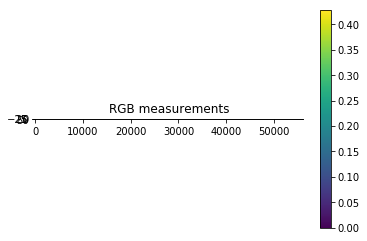

In [6]:
if(figure2 is True):
    # special case for figure 2, as before
    M = hw*ww
    Y_cal = np.zeros((P*C,M))
    # the following is IMPORTANT
    # !use mean intensity value of each pixel when all lights are on as a target to calibrate!
    x = np.ones((2, M))
    im = calib_rgb[0, xw1:xw2,yw1:yw2].reshape((M,3))
    x[0] = np.mean(im,axis=1)

    # R011a and R011b
    im = calib_rgb[r_011a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[0:3] = im.T
    im = calib_rgb[r_011b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[3:6] = im.T
    # R001a and R001b
    im = calib_rgb[r_001a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[6:9] = im.T
    im = calib_rgb[r_001b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[9:12] = im.T
    # G011a and G011b
    im = calib_rgb[g_011a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[12:15] = im.T
    im = calib_rgb[g_011b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[15:18] = im.T
    # G001a and G001b
    im = calib_rgb[g_001a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[18:21] = im.T
    im = calib_rgb[g_001b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[21:24] = im.T
    # B011a and B011b
    im = calib_rgb[b_011a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[24:27] = im.T
    im = calib_rgb[b_011b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[27:30] = im.T
    # B001a and B001b
    im = calib_rgb[b_001a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[30:33] = im.T
    im = calib_rgb[b_001b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[33:36] = im.T
    # r_111
    im = calib_rgb[r_111, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[36:39] = im.T
    # g_111
    im = calib_rgb[g_111, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[39:42] = im.T
    # b_111
    im = calib_rgb[b_111, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[42:45] = im.T

    # change types
    Y_cal = Y_cal.astype(np.float32)
    x = x.astype(np.float32)

    # plot things
    plt.imshow(Y_cal, interpolation='nearest')
    plt.colorbar()
    plt.title('RGB measurements')

In [7]:
if(figure2 is False):
    M = hw*ww
    Y_cal = np.zeros((P*C,M))
    # the following is IMPORTANT
    # !use mean intensity value of each pixel when all lights are on as a target to calibrate!
    x = np.ones((2, M))
    im = calib_rgb[all_on, xw1:xw2,yw1:yw2].reshape((M,3))
    x[0] = np.mean(im,axis=1)

    # R011a and R011b
    im = calib_rgb[r_011a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[0:3] = im.T
    im = calib_rgb[r_011b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[3:6] = im.T
    # R001a and R001b
    im = calib_rgb[r_001a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[6:9] = im.T
    im = calib_rgb[r_001b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[9:12] = im.T
    # G011a and G011b
    im = calib_rgb[g_011a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[12:15] = im.T
    im = calib_rgb[g_011b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[15:18] = im.T
    # G001a and G001b
    im = calib_rgb[g_001a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[18:21] = im.T
    im = calib_rgb[g_001b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[21:24] = im.T
    # B011a and B011b
    im = calib_rgb[b_011a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[24:27] = im.T
    im = calib_rgb[b_011b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[27:30] = im.T
    # B001a and B001b
    im = calib_rgb[b_001a, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[30:33] = im.T
    im = calib_rgb[b_001b, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[33:36] = im.T
    # rgb_1-5
    im = calib_rgb[rgb_1, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[36:39] = im.T
    im = calib_rgb[rgb_2, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[39:42] = im.T
    im = calib_rgb[rgb_3, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[42:45] = im.T
    im = calib_rgb[rgb_4, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[45:48] = im.T
    im = calib_rgb[rgb_5, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[48:51] = im.T

    # r_111
    im = calib_rgb[r_111, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[51:54] = im.T
    # g_111
    im = calib_rgb[g_111, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[54:57] = im.T
    # b_111
    im = calib_rgb[b_111, xw1:xw2,yw1:yw2].reshape((M,3))
    Y_cal[57:60] = im.T

    # change types
    Y_cal = Y_cal.astype(np.float32)
    x = x.astype(np.float32)

    # plot things
    plt.imshow(Y_cal, interpolation='nearest')
    plt.colorbar()
    plt.title('RGB measurements')

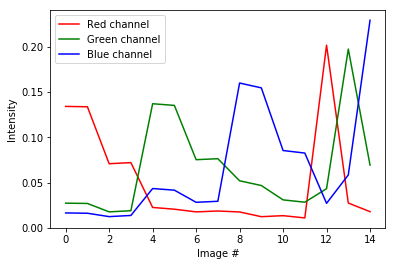

In [8]:
# sanity check - plot R-G-B average values over the whole calibration image
# the plot should look similar to the first plot in this notebook, except for the last 3 values
mean_rgb = np.zeros((P,C))
for i in range(P):
    mean_rgb[i,0] = np.mean(Y_cal[i*C])
    mean_rgb[i,1] = np.mean(Y_cal[i*C+1])
    mean_rgb[i,2] = np.mean(Y_cal[i*C+2])
plt.plot(mean_rgb[:,0], 'r')
plt.plot(mean_rgb[:,1], 'g')
plt.plot(mean_rgb[:,2], 'b')
plt.ylabel("Intensity")
plt.xlabel("Image #")
plt.legend(['Red channel', 'Green channel', 'Blue channel'])

# Minimize norm in Equation (16), by solving Equation (17) with IRLS


Retrieving values with norm  1.01  with Y.shape :  (2527200,)  and S.shape :  (2527200, 12)
('Iteration ', 10, ' over ', 50)
('Iteration ', 20, ' over ', 50)
('Iteration ', 30, ' over ', 50)
('Iteration ', 40, ' over ', 50)
('Iteration ', 50, ' over ', 50)


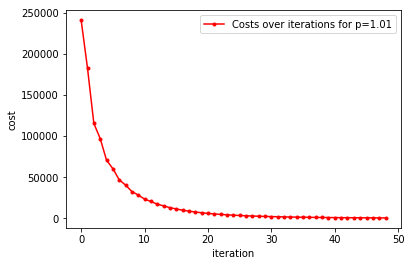

In [9]:
# Stack Y measurements and S matrix in 2 big matrices
Y_irls = np.zeros((P*C*M))
S_irls = np.zeros((P*C*M, C*L + C))
for i in range(P):
    for j in range(M):
        Y_irls[i*C*M+j*C : i*C*M+(j+1)*C] = Y_cal[i*C:(i+1)*C,j]
        S_irls[i*C*M+j*C : i*C*M+(j+1)*C] = S[i*C:(i+1)*C] 
        S_irls[i*C*M+j*C : i*C*M+(j+1)*C, :C*L] *= x[0,j]
        
# use IRLS to solve for gamma and D (vector u in Equation (17))
p = 1.01
print 'Retrieving values with norm ', p, ' with Y.shape : ', Y_irls.shape, ' and S.shape : ', S_irls.shape
u, n_iter, costs = IRLS(S_irls, Y_irls, p, eps0=0.001, max_iterations=50, verbose=True)
plt.plot(costs, 'r.-')
plt.xlabel('iteration')
plt.ylabel('cost')
plt.legend(['Costs over iterations for p={}'.format(p)])

In [10]:
# Save IRLS solution
D = u[9:12] 
Gm = u[0:9]
print('D : ', D)
print('Gm : ', Gm)
np.save(directory+'gamma.npy', Gm)
np.save(directory+'D.npy', D)

('D : ', array([0.00991319, 0.00908348, 0.00968876]))
('Gm : ', array([0.89984615, 0.13997705, 0.05821993, 0.08344772, 0.90825649,
       0.23382656, 0.03595527, 0.28694174, 1.06107014]))


# Calibrated parameters are now saved in numpy files 